<a href="https://colab.research.google.com/github/oduvanchikkatie-a11y/Spheroids-analysis/blob/main/Raw_data_spheroids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [1]:
!pip install czifile

In [2]:
!pip install pathlib

In [3]:
!pip install matplotlib

In [4]:
!pip install tifffile

In [5]:
!pip install czifile

In [6]:
!pip install skimage

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
!pip install pathlib

#General imports

In [8]:
import numpy as np
from tifffile import imread
from skimage.measure import (label, regionprops, perimeter, moments_central,
                             moments_normalized, moments_hu, find_contours, approximate_polygon)
from skimage.morphology import convex_hull_image
from skimage.filters import threshold_otsu
from scipy.spatial.distance import pdist
import xml.etree.ElementTree as ET
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
from google.colab import drive
import re
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Conversion czi images to tiff format
#####And creating folder with all tiff pics


In [9]:
from czifile import czi2tif

def convert_all_czi2tiff(BASE_FOLDER: str|pathlib.Path, TIFF_FOLDER: str|pathlib.Path) -> None:
  BASE_FOLDER_str, TIFF_FOLDER_str = str(BASE_FOLDER), str(TIFF_FOLDER)
  for root, dirs, files in os.walk(BASE_FOLDER_str):
    rel_path = os.path.relpath(root, BASE_FOLDER_str)
    os.makedirs(TIFF_FOLDER_str, exist_ok=True)
    czi_files = [f for f in files if f.lower().endswith('.czi')]
    for czi_file in czi_files:
      czi_path = os.path.join(root, czi_file)
      tiff_filename = os.path.splitext(czi_file)[0] + '.tif'
      tiff_path = os.path.join(TIFF_FOLDER_str, tiff_filename)
      if not os.path.join(TIFF_FOLDER_str, tiff_filename):
        try:
          czi2tif(czi_path, TIFF_FOLDER_str, bigtiff=True)
          print(f"File {tiff_filename} is converted: {os.path.getsize(TIFF_FOLDER_str)/1e9:.1f} GB")
        except Exception as e:
          print(f"Error: {e}")
  print("All files are converted")
  return None

Conversion example

In [10]:
convert_all_czi2tiff(BASE_FOLDER="/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_raw_images_czi_tif/Optical_microscopy_CZI", TIFF_FOLDER="/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_raw_images_czi_tif/Optical_microscopy_TIF")

All files are converted


#Decoding masks from rle to array of zeros and ones

In [11]:
def decode_cvat_rle(rle_str: str, h: int, w: int, occluded: str) -> np.ndarray:
  counts = [int(x.strip()) for x in rle_str.split(",") if x.strip() != ""]
  flat = np.zeros(h * w, dtype=np.uint8)
  idx = 0
  if occluded == "0":
    val = 0
  else: val = 1
  for c in counts:
    if idx + c > flat.size:
      raise ValueError(f"RLE overruns bbox size: idx={idx}, c={c}, size={flat.size}")
    if val == 1:
        flat[idx:idx + c] = 1
        val = 0
    elif val == 0:
        flat[idx:idx + c] = 0
        val = 1
    idx += c
  return flat.reshape((h, w))


####XML mask example
```
<mask label="Small spheroid" source="manual" occluded="0" rle="21, 5, 33, 16,
21, 23, 17, 28, 14, 30, 12, 32, 11, 32, 11, 33, 10, 33, 9, 35, 8, 36, 6, 38, 5,
 39, 3, 40, 3, 40, 3, 40, 3, 40, 2, 41, 2, 41, 2, 42, 1, 127, 1, 42, 1, 41, 3,
  40, 3, 40, 4, 39, 5, 37, 7, 36, 7, 36, 7, 35, 9, 33, 11, 31, 13, 27, 16, 26,
   18, 16, 1, 6, 21, 14, 34, 8, 38, 3, 23" left="1146" top="42" width="43" height="40" z_order="0">
</mask>
```


Decoding code example

In [12]:
binary_mask = decode_cvat_rle(rle_str="21, 5, 33, 16, 21, 23, 17, 28, 14, 30, 12, 32, 11, 32, 11, 33, 10, 33, 9, 35, 8, 36, 6, 38, 5, 39, 3, 40, 3, 40, 3, 40, 3, 40, 2, 41, 2, 41, 2, 42, 1, 127, 1, 42, 1, 41, 3, 40, 3, 40, 4, 39, 5, 37, 7, 36, 7, 36, 7, 35, 9, 33, 11, 31, 13, 27, 16, 26,18, 16, 1, 6, 21, 14, 34, 8, 38, 3, 23",
                h=40, w=43, occluded='0' )
binary_mask.sum()


np.uint64(1301)

Visualisation

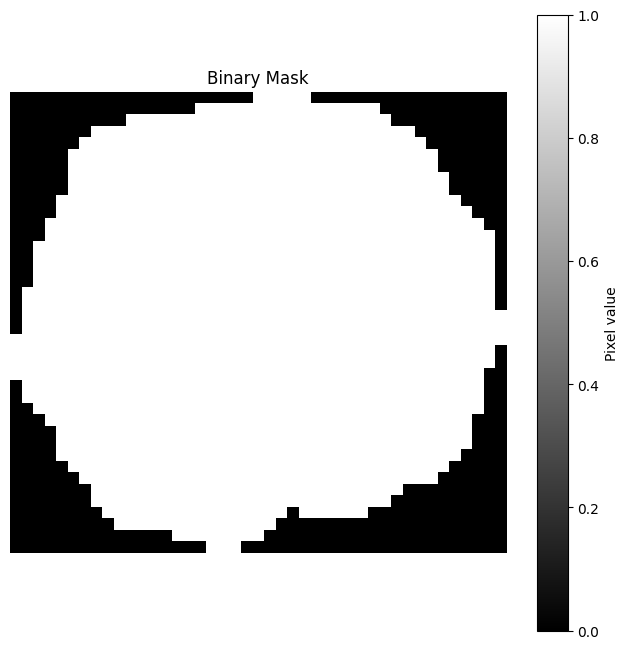

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(label='Pixel value')
plt.title('Binary Mask')
plt.axis('off')
plt.show()

#Features calculating

Auxiliary functions

In [14]:
def define_scale(image_name: str) -> float:
    coeff = 2.2
    if '10x' in image_name:
        coeff = 0.88
    return coeff

def find_file_recursive(filename, root_folder="/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_raw_images_czi_tif/Optical_microscopy_TIF", max_depth=10):
    if not filename:
        return None

    for root, dirs, files in os.walk(root_folder):
        # Ограничиваем глубину поиска
        current_depth = root[len(root_folder):].count(os.sep)
        if max_depth is not None and current_depth > max_depth:
            continue

        if filename in files:
            return os.path.join(root, filename)

    print(f"File not found: {filename}")
    return None

For correct moment Hu calculating backgound must be darker than spheroid.

Function invert_image cheks if invertion is required. If so the function inverts the image

In [15]:
import tifffile

def invert_image(tiff_path: str|pathlib.Path) -> np.ndarray:
  auto_invert = True
  tiff_path_str = str(tiff_path)
  try:
    image = tifffile.imread(tiff_path_str)
  except Exception as e:
    raise ValueError(f"TIFF file uploading error")
  was_inverted = False

  if auto_invert:
    try:
      thresh = threshold_otsu(image)
      object_pixels = image[image > thresh]
      background_pixels = image[image <= thresh]

      if len(object_pixels) > 0 and len(background_pixels) >0:
        object_mean = object_pixels.mean()
        background_mean = background_pixels.mean()
      if object_mean < background_mean:
        if image.dtype == np.uint8:
          image = 255 - image
        elif image.dtype == np.uint16:
          image = 65535 - image
        was_inverted = True
    except Exception as e:
      print(f"Automative invertion was failed")
  return image


Invertion example with visualisation

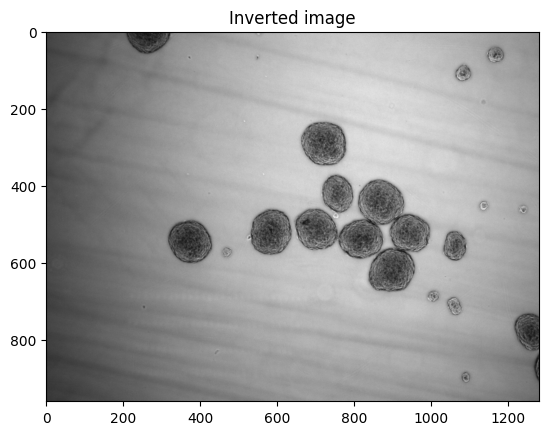

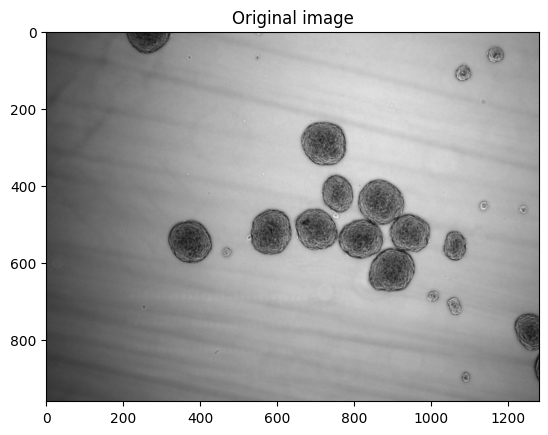

In [16]:
inverted = invert_image("/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_raw_images_czi_tif/Optical_microscopy_TIF/20250702_spheroidsCytDblebb_Y27632/20250702_ARPE_Y27632_0h.tif")
plt.imshow(inverted, cmap="gray")
plt.title("Inverted image")
plt.show()
plt.imshow(tifffile.imread("/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_raw_images_czi_tif/Optical_microscopy_TIF/20250702_spheroidsCytDblebb_Y27632/20250702_ARPE_Y27632_0h.tif"), cmap="gray")
plt.title("Original image")
plt.show()

You see same images because the darker the pixel the bigger its value as it should be for correct hu moments calculation.

Overlaying mask on full image to show only one masked object on full mask

In [17]:
from skimage.filters import threshold_otsu

def cut_image_overlay_mask(binary_mask: np.ndarray, image_processed: np.ndarray, left: int, top: int) -> np.ndarray:
  if binary_mask.dtype != bool:
      binary_mask = binary_mask.astype(bool)

  mask_height, mask_width = binary_mask.shape
  img_height, img_width = image_processed.shape

  full_mask = np.zeros((img_height, img_width), dtype=bool)
  if (top + mask_height > img_height) or (left + mask_width > img_width):
      raise ValueError(f"Mask is bigger than image: ",
                        f"image {img_height}x{img_width}",
                        f"mask {mask_height}x{mask_width} in position ({left, top})")
  full_mask[top:top + mask_height, left:left + mask_width] = binary_mask

  mask_pixels = np.sum(full_mask)

  if mask_pixels == 0:
      raise ValueError(f"Mask is empty")
  masked_image = image_processed.astype(np.float32) * full_mask.astype(np.float32)
  masked_image = masked_image[top:top + mask_height, left:left + mask_width]
#на картинке обрезать фон
  return masked_image

In [18]:
np.zeros((3,3)).astype(bool)

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

Example

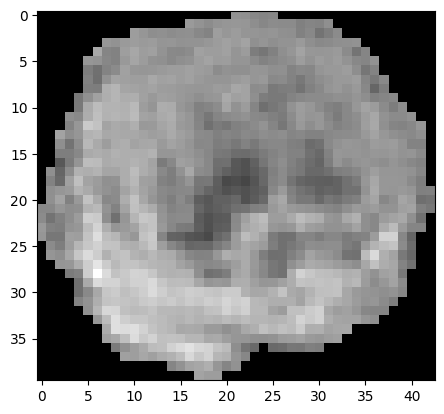

In [19]:
masked = cut_image_overlay_mask(binary_mask, inverted, 1146, 42)
plt.imshow(masked, cmap="gray")
plt.show()

Calculation Hu moments

In [20]:
from skimage.measure import moments_central, moments_normalized, moments_hu

def calc_hu(masked_image: np.ndarray) -> dict:
  try:
    hu_moments = moments_hu(moments_normalized(moments_central(masked_image)))
    hu_moments_log = np.zeros_like(hu_moments)
    for i in range(7):
        hu_moments_log[i] = -1 * np.copysign(1.0, hu_moments[i]) * np.log10(abs(hu_moments[i]))
  except Exception as e:
    print(f"Moments calculation failed: {e}")
    hu_moments = None
    hu_moments_log = None

  result = {"Logarithmic_hu_moment_1": hu_moments_log[0],
          "Logarithmic_hu_moment_2": hu_moments_log[1],
          "Logarithmic_hu_moment_3": hu_moments_log[2],
          "Logarithmic_hu_moment_4": hu_moments_log[3],
          "Logarithmic_hu_moment_5": hu_moments_log[4],
          "Logarithmic_hu_moment_6": hu_moments_log[5],
          "Logarithmic_hu_moment_7": hu_moments_log[6]}
  return result

def calculate_hu_moments_with_binary_mask(tiff_path: str|pathlib.Path, binary_mask: np.ndarray, left: int, top: int, auto_invert=True) -> dict:
  image_processed = invert_image(tiff_path)
  masked_image = cut_image_overlay_mask(binary_mask, image_processed, left, top)
  result = calc_hu(masked_image)
  return result

Example hu moments calculating

In [21]:
result = calc_hu(masked)
result

{'Logarithmic_hu_moment_1': np.float32(2.8217309),
 'Logarithmic_hu_moment_2': np.float32(7.9259105),
 'Logarithmic_hu_moment_3': np.float32(10.818486),
 'Logarithmic_hu_moment_4': np.float32(11.123778),
 'Logarithmic_hu_moment_5': np.float32(-22.186333),
 'Logarithmic_hu_moment_6': np.float32(15.2705),
 'Logarithmic_hu_moment_7': np.float32(-22.326872)}

Calculating minimum Feret diameter. It will be addad to all features

In [22]:
def min_feret_from_hull_mask(hull_mask: np.ndarray) -> float:
    contours = find_contours(hull_mask.astype(float), level=0.5)
    if not contours:
        return 0.0
    cont = max(contours, key=len)
    pts = np.stack([cont[:, 1], cont[:,0]], axis=1).astype(np.float64) #объединение в пары (y, x)
    if pts.shape[0] < 5:
        return 0.0

    diffs = np.diff(pts, axis=0) # векторы ребер контура
    lens = np.linalg.norm(diffs, axis=1)
    diffs = diffs[lens > 1e-6] # фильтрация нулевых рёбер
    if diffs.shape[0] < 2: # минимум два ребра для вычислений
        return 0.0

    normals = np.stack([-diffs[:, 1], diffs[:, 0]], axis=1)
    nlen = np.linalg.norm(normals, axis=1) # находим для каждого ребра нормаль
    normals = normals[nlen > 1e-9] / nlen[nlen > 1e-9][:, None] #нормируем нормали, None добавляет размерность для правильного деления
    if normals.shape[0] == 0: #проверка наличия нормалей
        return 0.0

    step = max(1, normals.shape[0] // 180) #минимум фере плавно меняется при повороте, достаточно будет рассмотреть только поворот на 180, а не 360. Шаг позволяет перебрать все направления по контуру
    widths = []
    for n in normals[::step]:
        proj = pts @ n # @ - это оператор матричного умножения
        widths.append(np.max(proj) - np.min(proj))
    return float(np.min(widths)) if widths else 0.0

Function for other features from mask
* area
* perimeter
* aspect ratio
* major and minor axis length
* circularity
* convexity
* roundness
* compactness
* vertices


In [23]:
def features_from_mask_except_hu(local_mask: np.ndarray, coeff: float) -> dict:
    mask = local_mask.astype(bool)
    lab = label(mask)
    props = regionprops(lab, spacing=(coeff, coeff))
    p = max(props, key=lambda x: x.area)
    area = float(p.area)
    perim = float(perimeter(p.image, neighborhood=8))
    bbox_w = int(p.bbox[3] - p.bbox[1])
    bbox_h = int(p.bbox[2] - p.bbox[0])
    aspect_ratio = float(bbox_w/bbox_h) if bbox_h > 0 else np.nan
    major = float(getattr(p, "axis_major_length", np.nan))
    circularity = float(4.0 * np.pi * area / (perim ** 2)) if perim > 0 else np.nan
    hull = convex_hull_image(p.image)
    hull_perim = float(perimeter(hull, neighborhood=8))
    convexity = float(hull_perim / perim) if perim > 0 else np.nan
    roundness = float((4.0 * area) / (np.pi * (major ** 2))) if (np.isfinite(major) and major > 0) else np.nan
    compactness = float((perim ** 2) / (4.0 * np.pi * area)) if area > 0 else np.nan
    contours = find_contours(mask.astype(float), level=0.5)
    vertices = np.nan
    if contours:
        cont = max(contours, key=len)
        poly = approximate_polygon(cont, tolerance=2.0)
        vertices = int(max(0, poly.shape[0] - 1))
    feret_min = float(min_feret_from_hull_mask(hull))

    return {
         "Area, mkm^2": p.area,
        "Perimeter, mkm": p.perimeter,
        "Aspect_ratio": aspect_ratio,
        "Extent": p.extent,
        "Equivalent_diameter, mkm": p.equivalent_diameter,
        "Major_axis_length, mkm": p.axis_major_length,
        "Minor_axis_length, mkm": p.axis_minor_length,
        "Eccentricity": p.eccentricity,
        "Circularity": circularity,
        "Solidity": p.solidity,
        "Convexity": convexity,
        "Roundness": roundness,
        "Compactness": compactness,
        "Feret_max": p.feret_diameter_max,
        "Feret_min": feret_min,
        "Num_vertices": vertices,
    }

def all_features_from_mask(tiff_path: str|pathlib.Path, binary_mask: np.ndarray, coeff: float, left: int, top: int) -> dict:
    feats = features_from_mask_except_hu(binary_mask, coeff)
    hu = calculate_hu_moments_with_binary_mask(tiff_path, binary_mask, left, top, auto_invert=True)
    feats.update(hu)
    return feats

Function for extracting all features from mask and creating CSV and EXCEL file

In [24]:
def stats_from_xml(
    xml_path: str,
    csv_excel_name: str,
) -> pd.DataFrame:

    root = ET.parse(xml_path).getroot()

    df = pd.DataFrame(columns=["Image name", "Label",
        "Area, mkm^2", "Perimeter, mkm", "Aspect_ratio", "Extent",
        "Equivalent_diameter, mkm", "Major_axis_length, mkm", "Minor_axis_length, mkm",
 "Eccentricity", "Circularity",
        "Solidity", "Convexity", "Roundness", "Compactness",
        "Feret_max", "Feret_min", "Num_vertices", "Logarithmic_hu_moment_1",
        "Logarithmic_hu_moment_2", "Logarithmic_hu_moment_3", "Logarithmic_hu_moment_4",
        "Logarithmic_hu_moment_5", "Logarithmic_hu_moment_6", "Logarithmic_hu_moment_7"
    ])
    for img in root.findall("image"):
        tiff_path = find_file_recursive(img.get("name"))
        image_name = img.get("name").removesuffix('.tif')
        coeff = 2.2
        target_label = ["Small spheroid", "Spheroid", "Spheroid_core"]
        for lab in target_label:
            for m in img.findall("mask"):
                image_name_column = {"Image name": image_name}
                if m.get("label") != lab:
                    continue
                if m.get("label") == lab:
                    label_name_column = {"Label": lab}
                w = int(m.get("width"))
                h = int(m.get("height"))
                t = int(m.get("top"))
                l = int(m.get("left"))
                rle_str = m.get("rle")
                occluded = m.get("occluded")

                local_mask = decode_cvat_rle(rle_str, h=h, w=w, occluded=occluded)
                feats = all_features_from_mask(tiff_path, local_mask, coeff, l, t)
                feats.update(label_name_column)
                feats.update(image_name_column)
                if feats is not None:
                    df = pd.concat([df, pd.DataFrame([feats])], ignore_index=True)
    if df.empty:
        out = pd.DataFrame([{"n_objects": 0}])
        out.to_csv(csv_excel_name, index=False)
        return out

    out = df
    out.to_csv(csv_excel_name + '.csv', index=False)
    out_excel = df.to_excel(csv_excel_name + '.xlsx', index=False)
    return out

#Final data


## Raw data

Using features extraction example

In [25]:
XML_PATH = "/content/drive/MyDrive/ИРМ/Spheroids/Spheroids_masks_xml/All_annotations.xml"
out = stats_from_xml(XML_PATH, 'Data')

/tmp/ipython-input-818/2758872376.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([feats])], ignore_index=True)


In [26]:
out

,Image name,Label,"Area, mkm^2","Perimeter, mkm",Aspect_ratio,Extent,"Equivalent_diameter, mkm","Major_axis_length, mkm","Minor_axis_length, mkm",Eccentricity,...,Feret_max,Feret_min,Num_vertices,Logarithmic_hu_moment_1,Logarithmic_hu_moment_2,Logarithmic_hu_moment_3,Logarithmic_hu_moment_4,Logarithmic_hu_moment_5,Logarithmic_hu_moment_6,Logarithmic_hu_moment_7
0,20250702_ARPE_Y27632_0h,Small spheroid,6296.84,301.518413,1.075000,0.756395,89.539855,93.548645,86.143234,0.389943,...,96.724971,7.071068,2,2.821731,7.925910,10.818486,11.123778,-22.186333,15.270500,-22.326872
1,20250702_ARPE_Y27632_0h,Small spheroid,2221.56,173.071905,0.961538,0.706154,53.184378,54.863320,51.936557,0.322253,...,58.248090,1.414214,1,2.887918,8.475974,11.143603,12.429825,24.868832,-16.908039,-24.227585
2,20250702_ARPE_Y27632_0h,Small spheroid,3025.00,202.804286,1.037037,0.826720,62.060854,65.595234,59.338757,0.426219,...,68.870894,5.500000,2,2.866492,7.566354,10.805177,12.027247,-24.888172,-16.245329,-23.443739
3,20250702_ARPE_Y27632_0h,Small spheroid,1936.00,160.626825,0.880000,0.727273,49.648683,52.525232,47.181730,0.439448,...,56.089215,1.414214,2,2.810546,7.284737,11.271086,12.294836,24.566610,-16.003025,-24.101955
4,20250702_ARPE_Y27632_0h,Small spheroid,5566.00,289.607143,0.883721,0.703794,84.183438,103.013527,69.668021,0.736627,...,100.528205,7.778175,4,2.827829,6.476811,11.146459,12.038030,23.961592,16.648848,23.683517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20250714_ARPE_control_3_4x,Spheroid_core,27331.48,640.059365,1.500000,0.768299,186.546298,233.051984,150.371419,0.763991,...,239.072290,8.485281,2,2.717523,6.202586,9.791497,10.125884,20.085667,13.231611,21.234222
716,20250714_ARPE_control_3_4x,Spheroid_core,22791.56,577.170635,1.090909,0.728046,170.349979,195.507278,150.025222,0.641212,...,194.497918,14.849242,4,2.765642,6.648854,10.260099,12.003525,-23.135868,-15.374693,-24.441551
717,20250714_ARPE_control_3_4x,Spheroid_core,35172.28,731.574920,1.344828,0.713921,211.619323,259.276548,174.646967,0.739102,...,272.489339,11.313708,3,2.650291,6.070678,9.514574,10.987361,21.338917,14.022720,21.453791
718,20250714_ARPE_control_3_4x,Spheroid_core,32640.96,681.352380,1.258824,0.741506,203.862113,229.741451,181.456313,0.613328,...,237.406403,15.556349,3,2.648907,6.513135,10.891186,10.862035,22.361584,-14.709291,-21.751337


## Grouped processed data

In [27]:
out['Date'] = out['Image name'].str.extract(r'(\d{8})')

for date, date_group in out.groupby('Date'):
  date_group['Image name'].nunique()
  date_group['Label'].value_counts()

In [28]:
def parse_image_inf(IMAGE_NAME: str) -> pd.DataFrame:
  date_match = re.search(r'(\d{8})', IMAGE_NAME)
  date = date_match.group(1) if date_match else "Unknown"

  if 'HDF' in IMAGE_NAME.upper():
      cell_line = 'HDF'
  elif 'ARPE' in IMAGE_NAME.upper():
      cell_line = 'ARPE-19'
  else:
      cell_line = 'Unknown'

  name_lower = IMAGE_NAME.lower()
  if 'blebb' in name_lower:
      agent = 'Blebbistatin'
  elif 'cyt' in name_lower:
      agent = 'Cytochalasin'
  elif 'y27632' in name_lower:
      agent = 'Y27632'
  elif 'control' in name_lower:
      agent = 'Control'
  else:
      agent = 'Unknown'

  return pd.Series({
      'Date': date,
      'Cell_line': cell_line,
      'Agent': agent
  })

In [29]:
out[['Date', 'Cell_line', 'Agent']] = out['Image name'].apply(parse_image_inf)
out.insert(0, 'Date', out.pop('Date'))
out.insert(1, "Cell_line", out.pop("Cell_line"))
out.insert(2, "Agent", out.pop('Agent'))

In [30]:
out['Date'] = pd.to_datetime(arg=out['Date'], dayfirst=True )
out

/tmp/ipython-input-818/83240458.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out['Date'] = pd.to_datetime(arg=out['Date'], dayfirst=True )


,Date,Cell_line,Agent,Image name,Label,"Area, mkm^2","Perimeter, mkm",Aspect_ratio,Extent,"Equivalent_diameter, mkm",...,Feret_max,Feret_min,Num_vertices,Logarithmic_hu_moment_1,Logarithmic_hu_moment_2,Logarithmic_hu_moment_3,Logarithmic_hu_moment_4,Logarithmic_hu_moment_5,Logarithmic_hu_moment_6,Logarithmic_hu_moment_7
0,2025-07-02,ARPE-19,Y27632,20250702_ARPE_Y27632_0h,Small spheroid,6296.84,301.518413,1.075000,0.756395,89.539855,...,96.724971,7.071068,2,2.821731,7.925910,10.818486,11.123778,-22.186333,15.270500,-22.326872
1,2025-07-02,ARPE-19,Y27632,20250702_ARPE_Y27632_0h,Small spheroid,2221.56,173.071905,0.961538,0.706154,53.184378,...,58.248090,1.414214,1,2.887918,8.475974,11.143603,12.429825,24.868832,-16.908039,-24.227585
2,2025-07-02,ARPE-19,Y27632,20250702_ARPE_Y27632_0h,Small spheroid,3025.00,202.804286,1.037037,0.826720,62.060854,...,68.870894,5.500000,2,2.866492,7.566354,10.805177,12.027247,-24.888172,-16.245329,-23.443739
3,2025-07-02,ARPE-19,Y27632,20250702_ARPE_Y27632_0h,Small spheroid,1936.00,160.626825,0.880000,0.727273,49.648683,...,56.089215,1.414214,2,2.810546,7.284737,11.271086,12.294836,24.566610,-16.003025,-24.101955
4,2025-07-02,ARPE-19,Y27632,20250702_ARPE_Y27632_0h,Small spheroid,5566.00,289.607143,0.883721,0.703794,84.183438,...,100.528205,7.778175,4,2.827829,6.476811,11.146459,12.038030,23.961592,16.648848,23.683517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2025-07-14,ARPE-19,Control,20250714_ARPE_control_3_4x,Spheroid_core,27331.48,640.059365,1.500000,0.768299,186.546298,...,239.072290,8.485281,2,2.717523,6.202586,9.791497,10.125884,20.085667,13.231611,21.234222
716,2025-07-14,ARPE-19,Control,20250714_ARPE_control_3_4x,Spheroid_core,22791.56,577.170635,1.090909,0.728046,170.349979,...,194.497918,14.849242,4,2.765642,6.648854,10.260099,12.003525,-23.135868,-15.374693,-24.441551
717,2025-07-14,ARPE-19,Control,20250714_ARPE_control_3_4x,Spheroid_core,35172.28,731.574920,1.344828,0.713921,211.619323,...,272.489339,11.313708,3,2.650291,6.070678,9.514574,10.987361,21.338917,14.022720,21.453791
718,2025-07-14,ARPE-19,Control,20250714_ARPE_control_3_4x,Spheroid_core,32640.96,681.352380,1.258824,0.741506,203.862113,...,237.406403,15.556349,3,2.648907,6.513135,10.891186,10.862035,22.361584,-14.709291,-21.751337


In [31]:
out.to_csv(path_or_buf='/content/drive/MyDrive/ИРМ/Spheroids/Raw_data.csv', index=False)